In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
%time
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

sys.path.append('..')
import project

CPU times: user 1 μs, sys: 1e+03 ns, total: 2 μs
Wall time: 4.29 μs


In [3]:
# configuration settings
data_root = '../data/phantom_lung2_0'
mesh_version = 10
num_levels = 3
num_conv_layers = 2
conv_channels = 8
conv_kernel_size = 3
output_func = 'relu'
batch_size = 1
learning_rate = 1e-5
interp_size = 5
interp_type = 'tent'
rho_value = 0

save_every = 10
save_prefix = '2024-11-19__lung2/asdf'
#save_prefix = f'2024-09-30__initial/train__batch_size__{mesh_radius}__{interp_radius}__{interp_sigma}__{output_func}__{batch_size}/'

Loading ../data/phantom_lung2_0/phantom5/phantom5_anat.nii.gz
Loading ../data/phantom_lung2_0/phantom5/phantom5_elast.nii.gz
Loading ../data/phantom_lung2_0/phantom5/phantom5_disp.nii.gz
Loading ../data/phantom_lung2_0/phantom5/phantom5_mask.nii.gz
CT


<IPython.core.display.Javascript object>


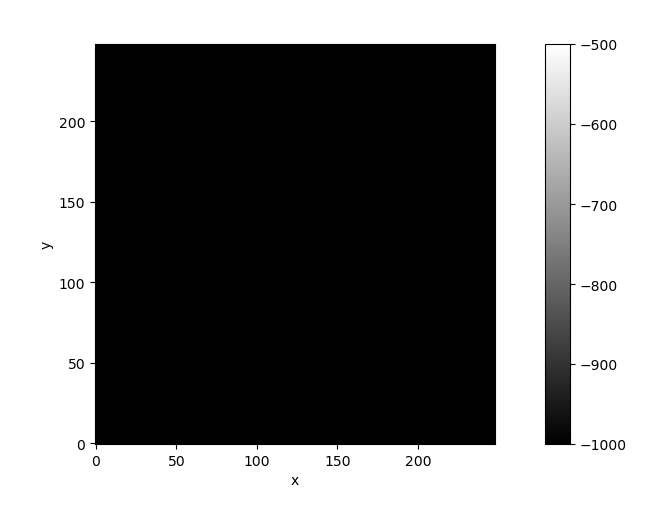

interactive(children=(SelectionSlider(description='z', options=((0.0, 0), (2.5, 1), (5.0, 2), (7.5, 3), (10.0,…

elasticity


<IPython.core.display.Javascript object>


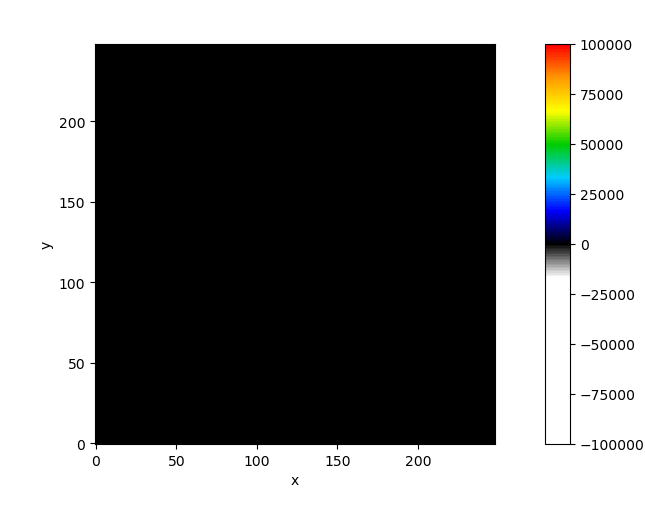

interactive(children=(SelectionSlider(description='z', options=((0.0, 0), (2.5, 1), (5.0, 2), (7.5, 3), (10.0,…

displacement


<IPython.core.display.Javascript object>


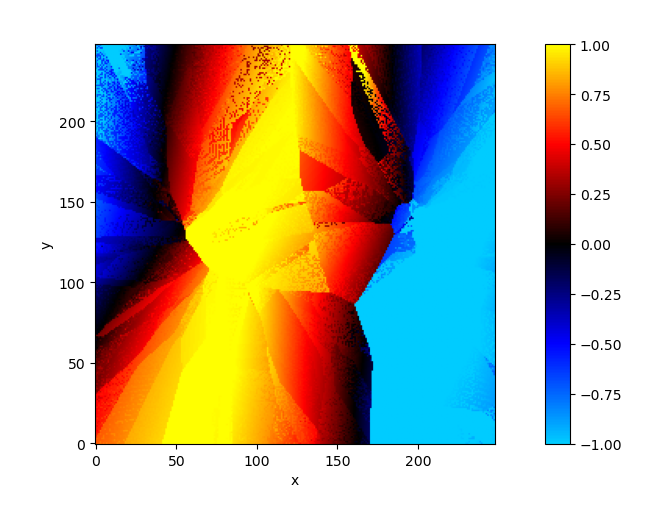

interactive(children=(SelectionSlider(description='z', options=((0.0, 0), (2.5, 1), (5.0, 2), (7.5, 3), (10.0,…

Loading ../data/phantom_lung2_0/phantom5/phantom5_mesh10.xdmf
Loading ../data/phantom_lung2_0/phantom5/phantom5_mesh10.xdmf... 5070


In [4]:
%autoreload
phantom_set = project.phantom.PhantomSet(data_root, num_phantoms=100)
phantom = phantom_set[5]
phantom.load_niftis()
project.visual.XArrayViewer(phantom.anat)
project.visual.XArrayViewer(phantom.elast)
project.visual.XArrayViewer(phantom.disp)
phantom.load_mesh(10)
phantom.mesh

In [5]:
all_examples = phantom_set.get_examples(mesh_version)
train_examples = all_examples[10:]
test_examples = all_examples[:10]
len(train_examples), len(test_examples)

(90, 10)

In [6]:
all_examples[0]

{'name': 'phantom0',
 'anat_file': PosixPath('../data/phantom_lung2_0/phantom0/phantom0_anat.nii.gz'),
 'elast_file': PosixPath('../data/phantom_lung2_0/phantom0/phantom0_elast.nii.gz'),
 'disp_file': PosixPath('../data/phantom_lung2_0/phantom0/phantom0_disp.nii.gz'),
 'mask_file': PosixPath('../data/phantom_lung2_0/phantom0/phantom0_mask.nii.gz'),
 'mesh_file': PosixPath('../data/phantom_lung2_0/phantom0/phantom0_mesh10.xdmf')}

In [7]:
train_data = project.data.Dataset(train_examples)
test_data = project.data.Dataset(test_examples)

In [8]:
model = project.model.UNet3D(
    in_channels=1,
    out_channels=1,
    num_levels=num_levels,
    num_conv_layers=num_conv_layers,
    conv_channels=conv_channels,
    conv_kernel_size=conv_kernel_size,
).cuda()

In [9]:
%autoreload
trainer = project.training.Trainer(
    model=model,
    train_data=train_data,
    test_data=test_data,
    batch_size=batch_size,
    learning_rate=learning_rate,
    rho_value=rho_value,
    interp_size=interp_size,
    interp_type=interp_type,
    save_every=save_every,
    save_prefix=save_prefix,
    sync_cuda=True
)

In [10]:
load_epoch = 200
if load_epoch:
    trainer.load_state(epoch=load_epoch)

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../project/training.py:319: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(model_path)
/oc

Loading ../data/phantom_lung2_0/phantom2/phantom2_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom2/phantom2_disp.nii.gz... (256, 256, 94, 3)
Loading ../data/phantom_lung2_0/phantom2/phantom2_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom2/phantom2_mesh10.xdmf... 5164
Loading ../data/phantom_lung2_0/phantom2/phantom2_elast.nii.gz... (256, 256, 94)
['phantom2'].

<IPython.core.display.Javascript object>


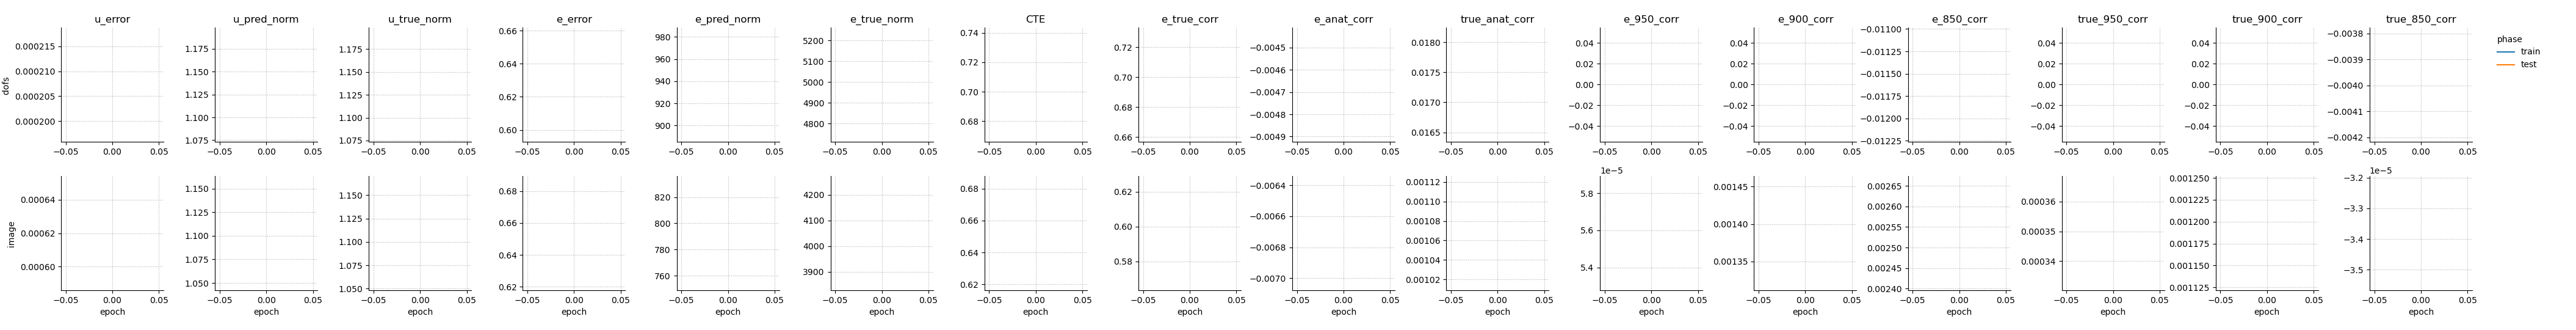

anat


<IPython.core.display.Javascript object>


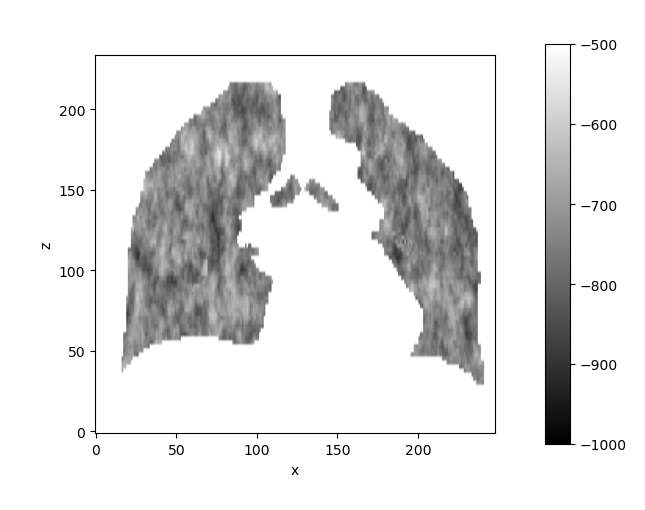

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

emph


<IPython.core.display.Javascript object>


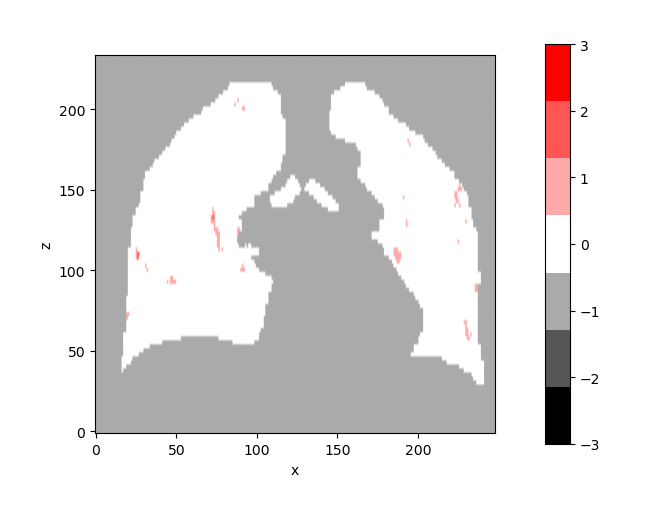

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

e_pred


<IPython.core.display.Javascript object>


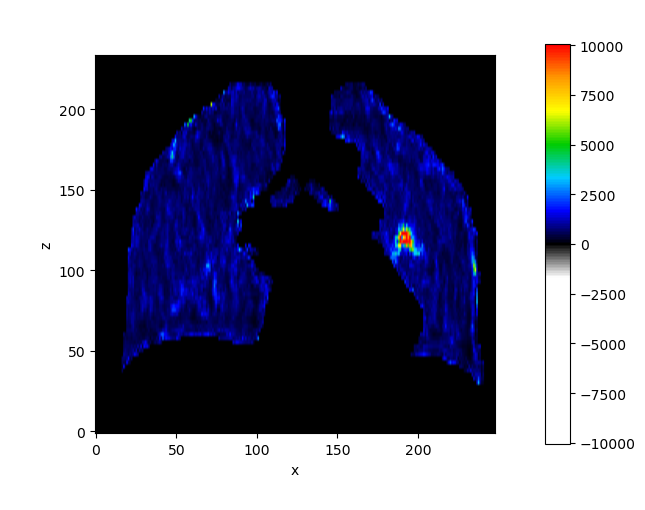

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

e_true


<IPython.core.display.Javascript object>


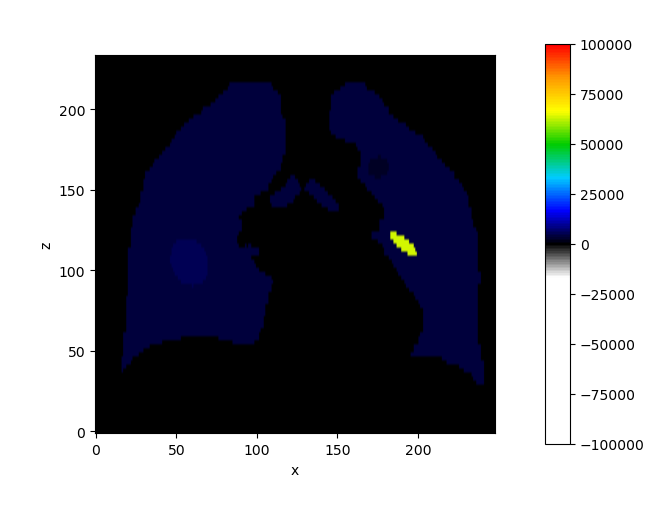

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

u_pred


<IPython.core.display.Javascript object>


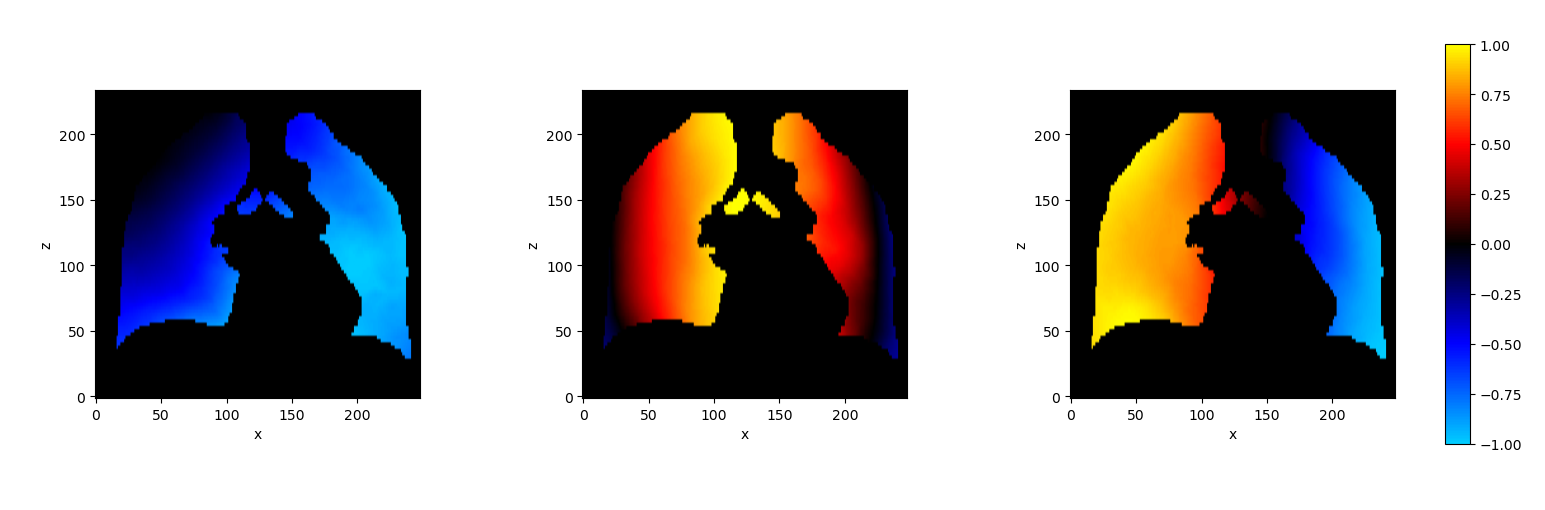

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

u_true


<IPython.core.display.Javascript object>


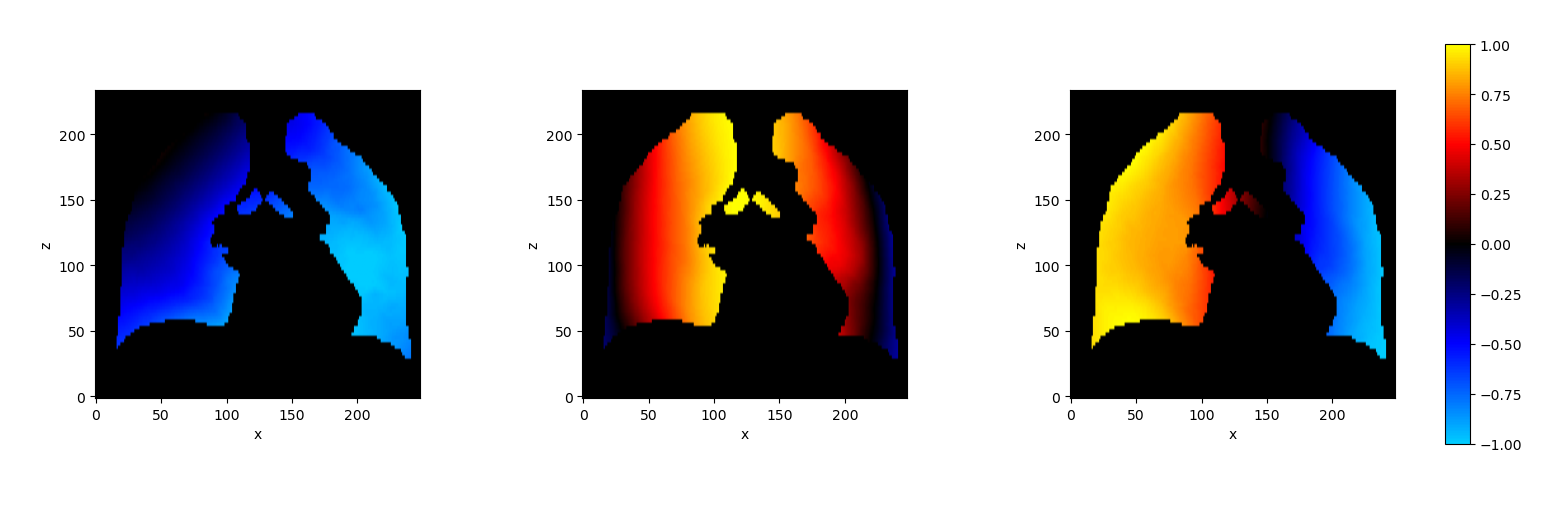

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

0.0002
CPU times: user 2min 28s, sys: 1.67 s, total: 2min 30s
Wall time: 2min 48s


In [11]:
%%time
# test forward pass and initialize viewers
trainer.timer.start()
trainer.run_next_batch(phase='test', epoch=0)

In [20]:
trainer.evaluator.metrics

u_error u_pred_norm u_true_norm   e_error  \
epoch batch example  phase rep                                                 
0     1     phantom2 test  dofs   0.000207    1.135829    1.136138  0.627345   
                           image   0.00062    1.102876    1.109326  0.653646   

                                 e_pred_norm  e_true_norm       CTE  \
epoch batch example  phase rep                                        
0     1     phantom2 test  dofs   936.889521  4987.744159  0.704865   
                           image  792.511169  4050.883545  0.652094   

                                 e_true_corr e_anat_corr true_anat_corr  \
epoch batch example  phase rep                                            
0     1     phantom2 test  dofs      0.69503   -0.004667       0.017294   
                           image    0.596176   -0.006709       0.001067   

                                 e_950_corr e_900_corr e_850_corr  \
epoch batch example  phase rep                                      
0     1     phantom2 test  dofs         NaN        NaN  -0.011622   
                           image   0.000056   0.001388   0.002535   

                                 true_950_corr true_900_corr true_850_corr  
epoch batch example  phase rep                                              
0     1     phantom2 test  dofs            NaN           NaN     -0.003997  
                           image      0.000349      0.001187     -0.000034

In [ ]:
trainer.save_metrics()
trainer.save_viewers()
trainer.save_state()

In [ ]:
%%time
trainer.timer.start()
trainer.train(num_epochs=200)

In [ ]:
trainer.evaluator.metrics

In [ ]:
trainer.timer.usage

In [ ]:
trainer.timer.usage.groupby(['phase', 'event']).mean().sort_values('time')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.usage, y='event', x='time', hue='phase', estimator='mean', ax=ax)
ax.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.usage , y='event', x='time', hue='phase', estimator='sum', ax=ax)
#ax.set_xscale('log')
ax.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(trainer.timer.usage, y='time', x='phase', estimator='mean', ax=ax)
ax.set_ylabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(trainer.timer.usage, y='time', x='phase', estimator='sum', ax=ax)
ax.set_ylabel('time (s)')
fig.tight_layout()

In [ ]:
anat_image, E_true_image, u_image, mask, resolution, pde, example_name = test_data[6]
anat_image.shape

In [ ]:
E_pred_image = model.forward(anat_image.unsqueeze(0).cuda())[0].cpu() * 1000
mask.shape, mask.max()

In [ ]:
E_pred_image.mean()

In [ ]:
%autoreload
import torch

# compute contrast relative to background
eps = 1e-6
C_true_image = torch.log10(E_true_image / E_true_image[mask == 1].median() + eps)
C_pred_image = torch.log10(E_pred_image / E_pred_image[mask == 1].median() + eps)
CTE_image = 10**-(C_pred_image - C_true_image).abs()

z = 45
project.visual.XArrayViewer(
    project.utils.as_xarray( (C_true_image) * (mask > 0), dims=['c', 'x', 'y', 'z'], name='C_true'),
).update_index(c=0, z=z)

project.visual.XArrayViewer(
    project.utils.as_xarray( (C_pred_image) * (mask > 0), dims=['c', 'x', 'y', 'z'], name='C_pred'),
).update_index(c=0, z=z)

project.visual.XArrayViewer(
    project.utils.as_xarray( (CTE_image) * (mask > 0), dims=['c', 'x', 'y', 'z'], name='CTE'),
).update_index(c=0, z=z)

print(CTE_image[mask > 1].median().item())

Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case8Deploy/medpseg/case8_T00_consolidation.nii.gz... (256, 256, 94)


In [23]:
os.listdir('/ocean/projects/asc170022p/shared/Data/4DLungCT')

['Emory', 'TCIA']